In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs



# ENSEMBLE MACHINE LEARNIGN MODEL FOR TOMATO LEAF DISEASE DETECTION

**Import required modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

2024-08-31 21:11:30.683077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 21:11:30.683202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 21:11:30.852977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Data Loading and preprocessing**

In [2]:
# Load Train and Validation Data
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)
train_data = train_data.map(lambda x, y: (x / 255.0, y))

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)
val_data = val_data.map(lambda x, y: (x / 255.0, y))

# Extract features and labels from the dataset
train_images, train_labels = next(iter(train_data.unbatch().batch(10000)))
val_images, val_labels = next(iter(val_data.unbatch().batch(10000)))

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [4]:
# CNN model
cnn_model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(256, activation='relu', name='my_dense'),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,658 (279.91 KB)

 Trainable params: 71,658 (279.91 KB)

 Non-trainable params: 0 (0.00 B)

# CNN Model Archirecture

In [3]:


# CNN model
cnn_model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(256, activation='relu', name='my_dense'),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

cnn_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Train the simplified CNN model
cnn_history = cnn_model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels))

Epoch 1/100
  3/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.1285 - loss: 2.3025   

I0000 00:00:1725138766.981867     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.1529 - loss: 2.1850 - val_accuracy: 0.3420 - val_loss: 1.6662
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3820 - loss: 1.6603 - val_accuracy: 0.4660 - val_loss: 1.3323
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4913 - loss: 1.3579 - val_accuracy: 0.5160 - val_loss: 1.2863
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5917 - loss: 1.1070 - val_accuracy: 0.6670 - val_loss: 0.8715
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6399 - loss: 0.9633 - val_accuracy: 0.7270 - val_loss: 0.7592
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6913 - loss: 0.8555 - val_accuracy: 0.7250 - val_loss: 0.7209
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7159 - loss: 0.7829 - val_accuracy: 0.7950 - val_loss: 0.6009
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7463 - loss: 0.7073 - val_

**Feature extraction for Gradient Boost Model using the CNN Model**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define the feature extractor model using the updated CNN model
feature_extractor_model = Model(
    [cnn_model.inputs],  # Input tensor of the main model
    outputs=cnn_model.get_layer('my_dense').output  # Output tensor of the 'my_dense' layer
)

# Extract features for training and validation sets
train_features = feature_extractor_model.predict(train_images, batch_size=32)
val_features = feature_extractor_model.predict(val_images, batch_size=32)

# Reshape features to 2D arrays (n_samples, n_features)
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


# XGBoost Model

In [6]:
# Train an XGBoost model on the extracted features
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05)
xgb_model.fit(train_features, np.argmax(train_labels, axis=1))

# Predictions from XGBoost
xgb_predictions_train = xgb_model.predict(train_features)
xgb_predictions_val = xgb_model.predict(val_features)


In [11]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for training and validation sets
xgb_train_accuracy = accuracy_score(np.argmax(train_labels, axis=1), xgb_predictions_train)
xgb_val_accuracy = accuracy_score(np.argmax(val_labels, axis=1), xgb_predictions_val)

print(f"XGB Model Training Accuracy: {xgb_train_accuracy * 100:.2f}%")
print(f"XGB Model Validation Accuracy: {xgb_val_accuracy * 100:.2f}%")

XGB Model Training Accuracy: 100.00%
XGB Model Validation Accuracy: 96.40%


# Stacking CNN and XGBoost Models

In [13]:
# Stacking: Combine CNN and XGBoost predictions
cnn_predictions_train = np.argmax(cnn_model.predict(train_images), axis=1)
cnn_predictions_val = np.argmax(cnn_model.predict(val_images), axis=1)

# Stack predictions for the meta-model
stacked_train = np.column_stack((cnn_predictions_train, xgb_predictions_train))
stacked_val = np.column_stack((cnn_predictions_val, xgb_predictions_val))

# Meta-model: Logistic Regression
meta_model = LogisticRegression(max_iter=100000,)
meta_model.fit(stacked_train, np.argmax(train_labels, axis=1))

# Final predictions and evaluation
final_predictions = meta_model.predict(stacked_val)
accuracy = accuracy_score(np.argmax(val_labels, axis=1), final_predictions)

print(f"Stacked Model Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Stacked Model Accuracy: 96.00%


# MODELS EVALUATION

**Confusion Matrixes**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


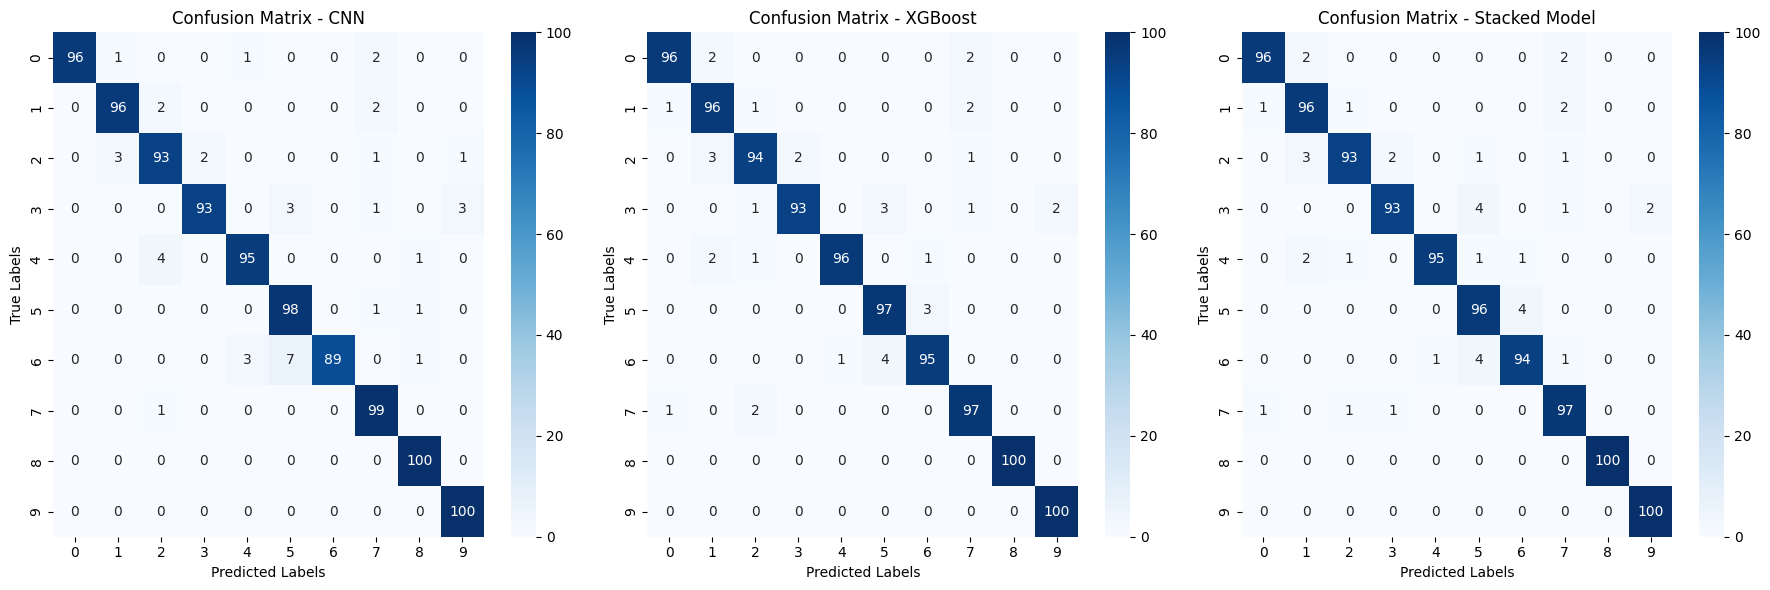

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for each model
cnn_predictions = np.argmax(cnn_model.predict(val_images), axis=1)
xgb_predictions = xgb_model.predict(val_features)
stacked_predictions = meta_model.predict(stacked_val)

# Generate confusion matrices
cnn_cm = confusion_matrix(np.argmax(val_labels, axis=1), cnn_predictions)
xgb_cm = confusion_matrix(np.argmax(val_labels, axis=1), xgb_predictions)
stacked_cm = confusion_matrix(np.argmax(val_labels, axis=1), stacked_predictions)

# Plot the confusion matrix for CNN
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Plot the confusion matrix for XGBoost
plt.subplot(1, 3, 2)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# # Plot the confusion matrix for the Stacked Model
plt.subplot(1, 3, 3)
sns.heatmap(stacked_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Stacked Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()


# *Accuracy and Loss Curves*

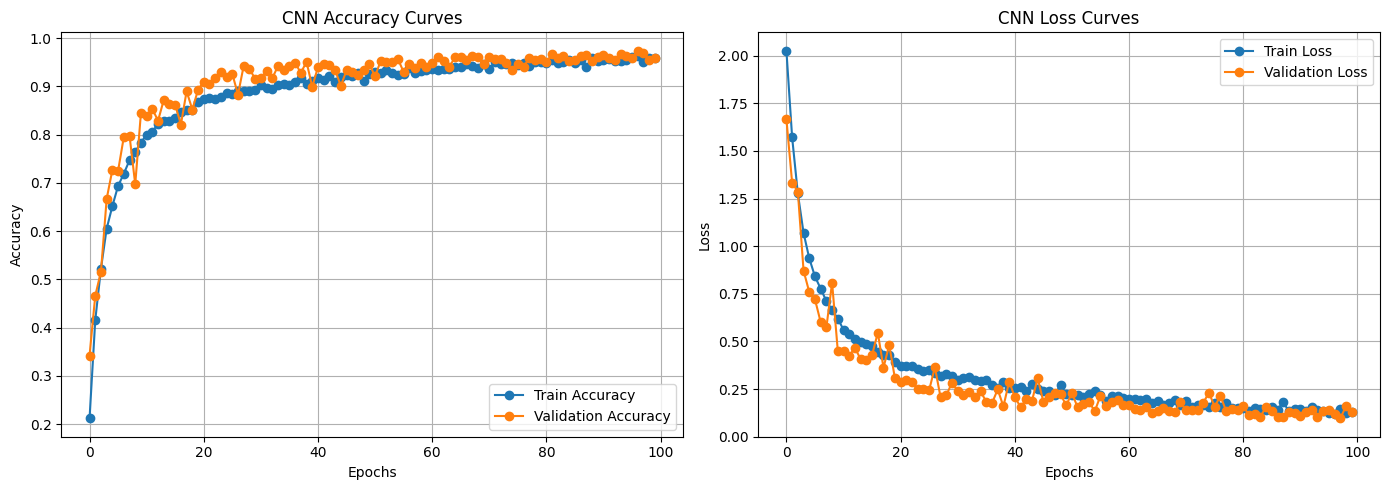

In [9]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, title="Model"):
    # Plot Accuracy Curves
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy Curves')
    plt.legend()
    plt.grid(True)

    # Plot Loss Curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss curves
plot_accuracy_loss(cnn_history, title="CNN")



# XGBoost Loss Curve

[0]	validation_0-mlogloss:2.06504	validation_0-merror:0.00980	validation_1-mlogloss:2.07378	validation_1-merror:0.04100
[1]	validation_0-mlogloss:1.87857	validation_0-merror:0.00950	validation_1-mlogloss:1.89575	validation_1-merror:0.04100
[2]	validation_0-mlogloss:1.72475	validation_0-merror:0.00810	validation_1-mlogloss:1.74771	validation_1-merror:0.04300
[3]	validation_0-mlogloss:1.59384	validation_0-merror:0.00840	validation_1-mlogloss:1.62154	validation_1-merror:0.04300
[4]	validation_0-mlogloss:1.48022	validation_0-merror:0.00800	validation_1-mlogloss:1.51226	validation_1-merror:0.04300
[5]	validation_0-mlogloss:1.37993	validation_0-merror:0.00780	validation_1-mlogloss:1.41579	validation_1-merror:0.04300
[6]	validation_0-mlogloss:1.29033	validation_0-merror:0.00760	validation_1-mlogloss:1.33013	validation_1-merror:0.04300
[7]	validation_0-mlogloss:1.20937	validation_0-merror:0.00750	validation_1-mlogloss:1.25275	validation_1-merror:0.04100
[8]	validation_0-mlogloss:1.13583	valida

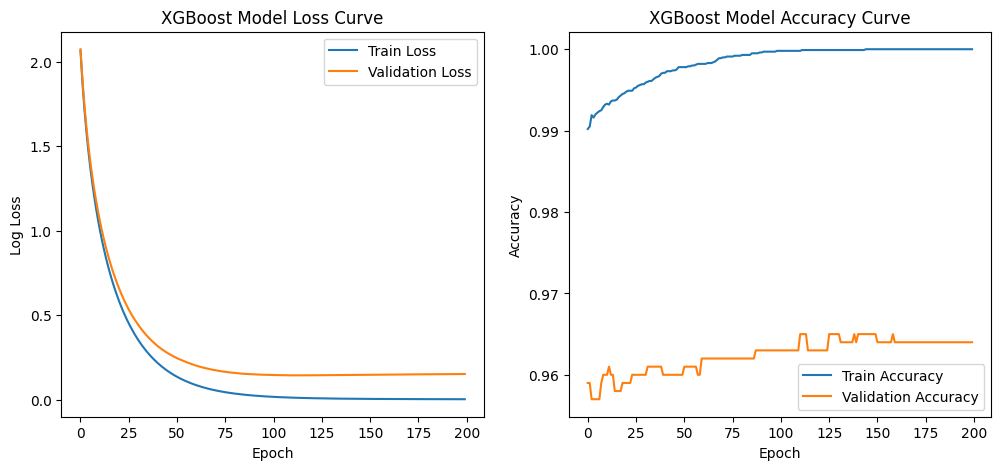

In [10]:
import matplotlib.pyplot as plt

# Train an XGBoost model with evaluation metrics
eval_set = [(train_features, np.argmax(train_labels, axis=1)), 
            (val_features, np.argmax(val_labels, axis=1))]

xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric=['mlogloss', 'merror'])
xgb_model.fit(train_features, np.argmax(train_labels, axis=1), 
              eval_set=eval_set, verbose=True)

# Extract training and validation logs from evals_result_
evals_result = xgb_model.evals_result()

# Plot Loss (mlogloss) Curve
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(evals_result['validation_0']['mlogloss'], label='Train Loss')
plt.plot(evals_result['validation_1']['mlogloss'], label='Validation Loss')
plt.title('XGBoost Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

# Accuracy Curve (using merror, so we subtract it from 1 to get accuracy)
plt.subplot(1, 2, 2)
plt.plot(1 - np.array(evals_result['validation_0']['merror']), label='Train Accuracy')
plt.plot(1 - np.array(evals_result['validation_1']['merror']), label='Validation Accuracy')
plt.title('XGBoost Model Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Stacked Model Loss Curve

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

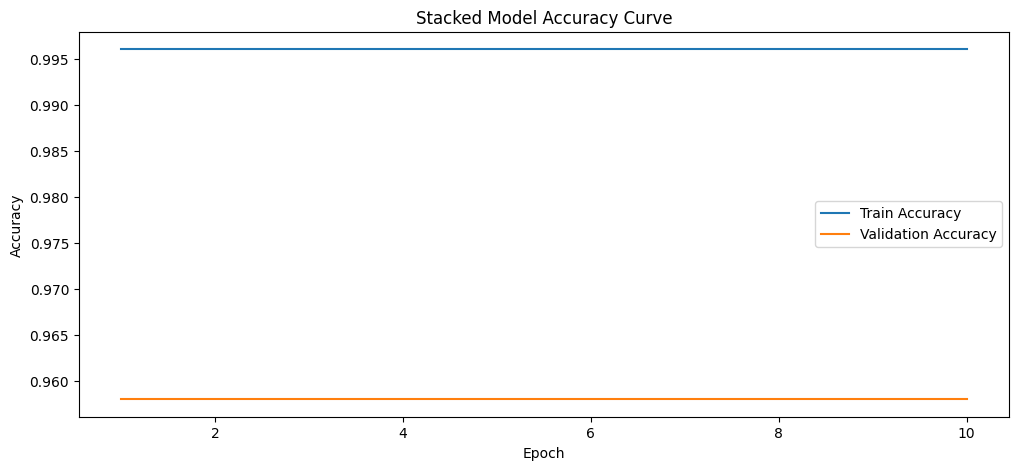

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize lists to store accuracy per epoch
train_accuracies = []
val_accuracies = []

# Train the Stacked Model for a number of epochs manually (you can define the number of epochs)
epochs = 10
for epoch in range(epochs):
    meta_model = LogisticRegression()
    meta_model.fit(stacked_train, np.argmax(train_labels, axis=1))
    
    # Predict and calculate accuracy
    train_accuracy = accuracy_score(np.argmax(train_labels, axis=1), meta_model.predict(stacked_train))
    val_accuracy = accuracy_score(np.argmax(val_labels, axis=1), meta_model.predict(stacked_val))
    
    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
#     print(f'Epoch {epoch+1}/{epochs}: Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Stacked Model Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Learning Curves

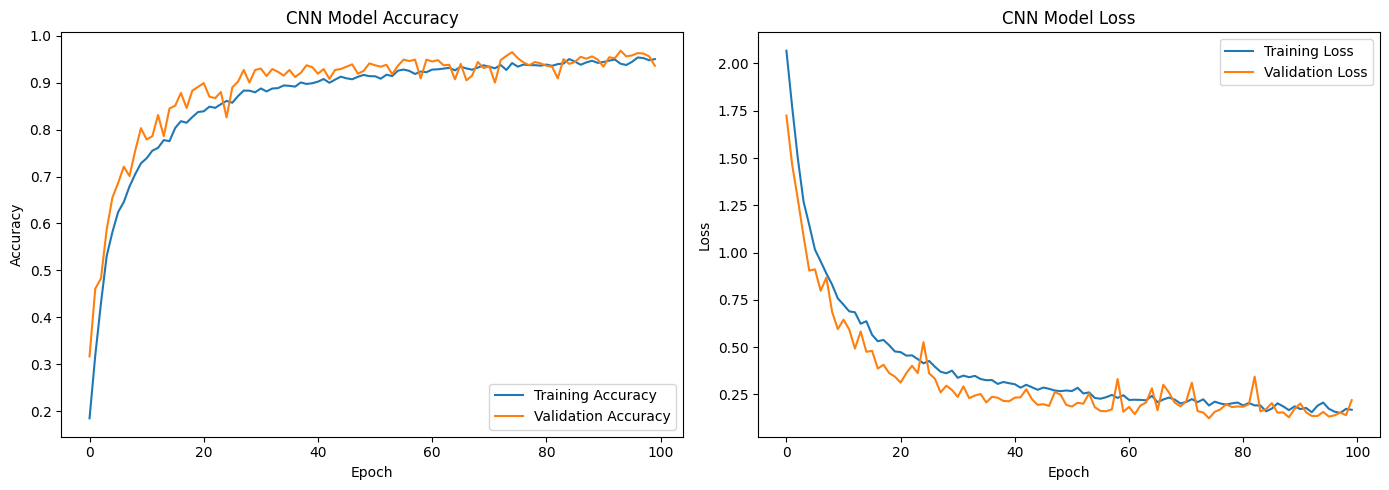

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Learning curve for the CNN model
def plot_cnn_learning_curve(cnn_history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'], label='Training Loss')
    plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Plot learning curve for XGBoost
def plot_xgb_learning_curve(xgb_model, train_features, train_labels):
    plt.figure(figsize=(10, 6))
    
    # Use sklearn's learning_curve function to generate data
    train_sizes, train_scores, val_scores = learning_curve(
        xgb_model, train_features, np.argmax(train_labels, axis=1), cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    
    # Mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Mean and standard deviation for validation scores
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    
    plt.title('Learning Curve for XGBoost Model')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curve for Stacked Model
def plot_stacked_learning_curve(meta_model, stacked_train, train_labels):
    plt.figure(figsize=(10, 6))
    
    # Use sklearn's learning_curve function to generate data
    train_sizes, train_scores, val_scores = learning_curve(
        meta_model, stacked_train, np.argmax(train_labels, axis=1), cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    
    # Mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Mean and standard deviation for validation scores
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    
    plt.title('Learning Curve for Stacked Model')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Call functions with appropriate arguments
plot_cnn_learning_curve(cnn_history)
plot_xgb_learning_curve(xgb_model, train_features, train_labels)
plot_stacked_learning_curve(meta_model, stacked_train, train_labels)


# Save The Stacked Model

In [10]:
import joblib

# Save the CNN model (if you want to use it later)
cnn_model.save('cnn_model_96.h5')
cnn_model.save('cnn_model_96.keras')

# Save the XGBoost model
joblib.dump(xgb_model, 'xgb_model_96.json')

# Save the meta-model (Logistic Regression in this case)
joblib.dump(meta_model, 'meta_model_96.pkl')


['meta_model_96.json']

In [13]:
# xgb_model.save_model('xgb_model_96.json')
joblib.dump(meta_model, 'meta_model_96.pkl')

['meta_model_96.pkl']

# Loading the Saved Models

In [12]:
import tensorflow as tf
import joblib

# Load the CNN model
cnn_model = tf.keras.models.load_model('cnn_model.h5')

# Load the XGBoost model
xgb_model = joblib.load('xgb_model.pkl')

# Load the meta-model
meta_model = joblib.load('meta_model.pkl')

# Assuming you have new data to predict
new_images = ...  # Load and preprocess your new image data
new_features = feature_extractor.predict(new_images)
new_features = new_features.reshape(new_features.shape[0], -1)

# Get predictions from the XGBoost model
xgb_predictions = xgb_model.predict(new_features)

# Get predictions from the CNN model
cnn_predictions = np.argmax(cnn_model.predict(new_images), axis=1)

# Stack predictions for the meta-model
stacked_predictions = np.column_stack((cnn_predictions, xgb_predictions))

# Get final predictions from the meta-model
final_predictions = meta_model.predict(stacked_predictions)

print("Final Predictions:", final_predictions)


NameError: name 'feature_extractor' is not defined